# Creating Sim Brains for CVAE Training

In [1]:
pwd

'/mmfs1/data/bergerar/BC-sim/Code'

In [52]:
import ants
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Sphere Function

In [4]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

## Brain Resize

In [5]:
brain_size = (64,64,64)

In [6]:
pwd

'/mmfs1/data/bergerar/BC-sim/Code'

In [7]:
temp = ants.image_read('../Misc/Atlas_brain_2mm.nii')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize() # This normalizes the data to 0-1

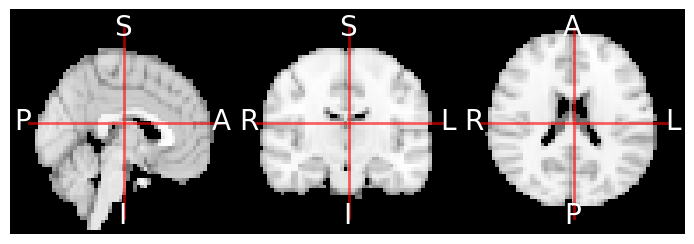

In [8]:
temp.plot_ortho(flat=True)

In [9]:
temp.max()

/data/bergerar/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1.0

In [10]:
# make sure image was sized correctly
brain_size = temp.shape
print(brain_size)

(64, 64, 64)


## Alteration Function

In [23]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True,tmp_dir='/scratch/bergerar/'):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly',outprefix=tmp_dir) # learns a vector field from small to big sphere
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='nearestNeighbor')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    J = J-1
    #J[abs(J.numpy())<.25]=0
    if do_plot==True:
        warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

In [25]:
tx_log_td = []
tx_log_adhd = []
for s in tqdm( range(500) ):
    sub = f'sub-{s:04d}'

    td_sphere1 = np.random.uniform(low=10.0,high=35,size=1)
    td_sphere_diff = np.random.uniform(low=-5.0,high=5.0,size=1)
    td_sphere2 = td_sphere1+td_sphere_diff
    tx_log_td.append( (td_sphere1,td_sphere2) )
    #print((td_sphere1,td_sphere2))

    TD_brain = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False)
    #TD_brain.plot_ortho(flat=True)

    adhd_sphere1 = np.random.uniform(low=5.0,high=15,size=1)
    adhd_sphere_diff = np.random.uniform(low=-3.0,high=3.0,size=1)
    adhd_sphere2 = adhd_sphere1+adhd_sphere_diff
    tx_log_adhd.append( (adhd_sphere1,adhd_sphere2) )
    #print((adhd_sphere1,adhd_sphere2))

    ADHD_brain = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False)
    #ADHD_brain.plot_ortho(flat=True)

    TD_brain.to_filename(os.path.join('../synth-data-01','TD-'+sub+'.nii.gz'))
    ADHD_brain.to_filename(os.path.join('../synth-data-01','ADHD-'+sub+'.nii.gz'))
    
np.save(file='../synth-data-01/tx_log_adhd1.npy',arr=np.array(tx_log_adhd)[:,:,0])
np.save(file='../synth-data-01/tx_log_td1.npy',arr=np.array(tx_log_td)[:,:,0])

100%|██████████| 500/500 [46:48<00:00,  5.62s/it]


/data/bergerar/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 500/500 [00:03<00:00, 141.73it/s]


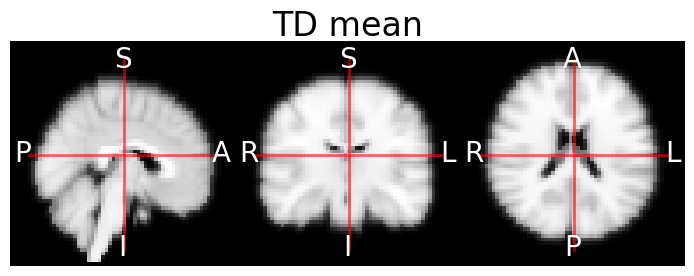

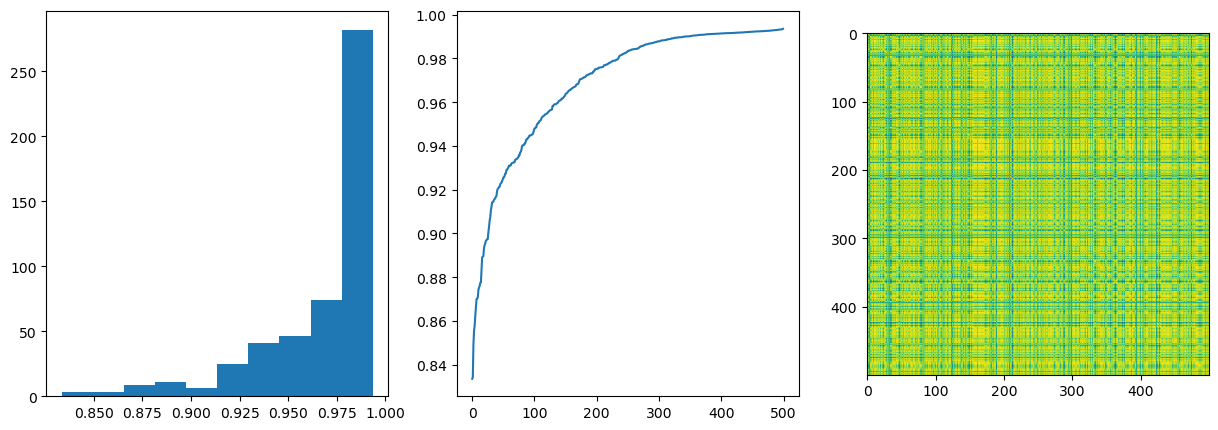

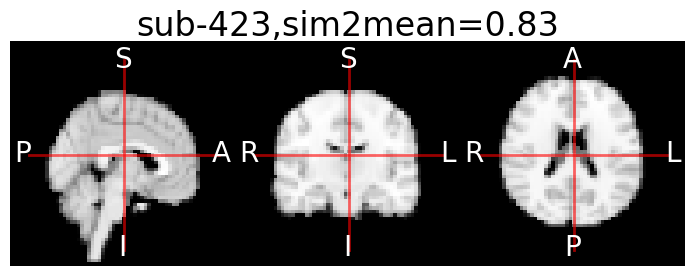

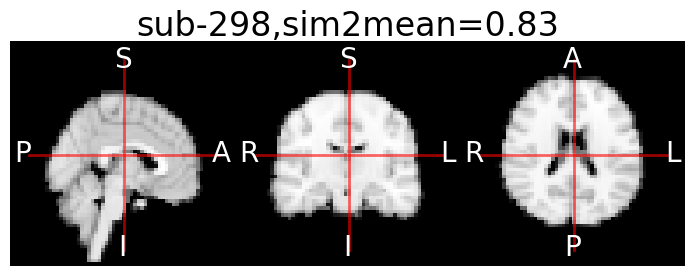

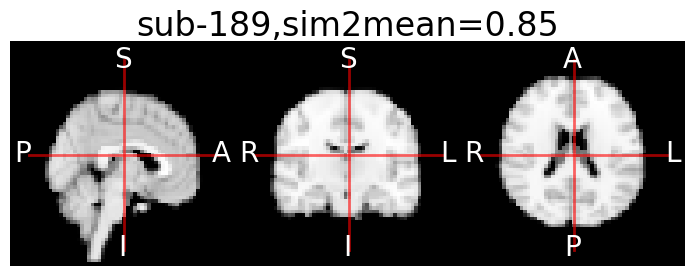

In [94]:
td_collect = np.array([ants.image_read(f'../synth-data-01/TD-sub-{s:04d}.nii.gz').numpy() for s in tqdm(range(500))]) # Load in all the subs as numpy arrays
td_collect_flat = td_collect.reshape(td_collect.shape[0],-1) # Flatten from 4d to 2d
td_collect_flat_mean = td_collect_flat.mean(axis=0)  # Calc mean
sim2mean = np.array([np.corrcoef(td_collect_flat_mean,td_collect_flat[s,:])[0,1] for s in range(500)]) # calc similarity to mean image for each sub
temp.new_image_like(td_collect.mean(axis=0)).plot_ortho(flat=True,title='TD mean') # Plot mean


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(sim2mean) # plot hist
plt.subplot(1,3,2)
plt.plot(np.sort(sim2mean)) # plot sorted sim2mean plot
plt.subplot(1,3,3)
plt.imshow(np.corrcoef(td_collect_flat)) # similarity matrix
plt.show()

# Plot 3 weirdest images
for i in range(3):
    temp.new_image_like(td_collect[np.argsort(sim2mean)[i],:,:,:]).plot_ortho(flat=True,title=f'sub-{np.argsort(sim2mean)[i]},sim2mean={sim2mean[np.argsort(sim2mean)[i]]:.2f}')

/data/bergerar/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 500/500 [00:03<00:00, 133.58it/s]


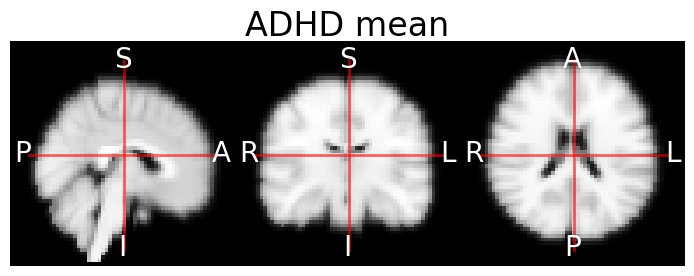

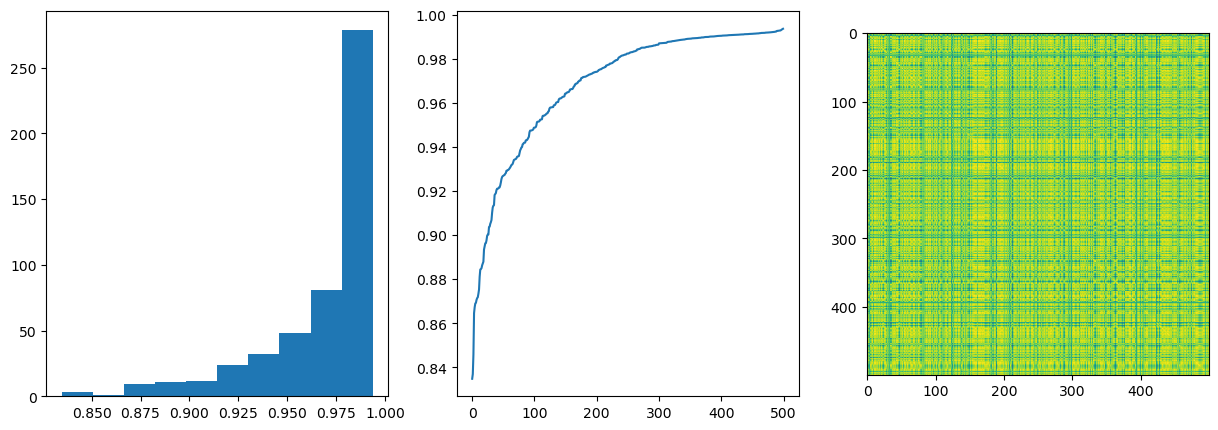

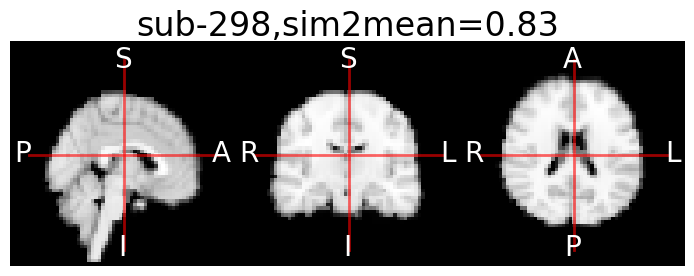

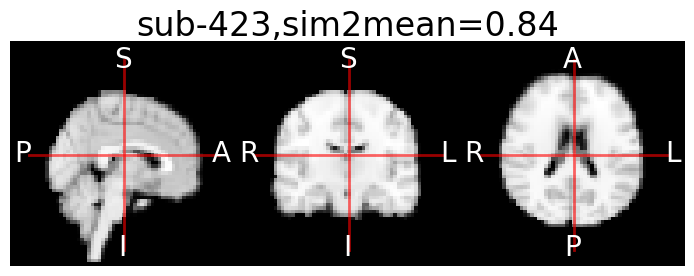

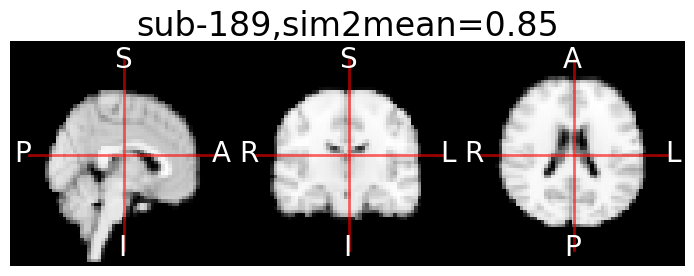

In [95]:
adhd_collect = np.array([ants.image_read(f'../synth-data-01/ADHD-sub-{s:04d}.nii.gz').numpy() for s in tqdm(range(500))]) # Load in all the subs as numpy arrays
adhd_collect_flat = adhd_collect.reshape(adhd_collect.shape[0],-1) # Flatten from 4d to 2d
adhd_collect_flat_mean = adhd_collect_flat.mean(axis=0)  # Calc mean
sim2mean = np.array([np.corrcoef(adhd_collect_flat_mean,adhd_collect_flat[s,:])[0,1] for s in range(500)]) # calc similarity to mean image for each sub
temp.new_image_like(adhd_collect.mean(axis=0)).plot_ortho(flat=True,title='ADHD mean') # Plot mean


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(sim2mean) # plot hist
plt.subplot(1,3,2)
plt.plot(np.sort(sim2mean)) # plot sorted sim2mean plot
plt.subplot(1,3,3)
plt.imshow(np.corrcoef(adhd_collect_flat)) # similarity matrix
plt.show()

# Plot 3 weirdest images
for i in range(3):
    temp.new_image_like(adhd_collect[np.argsort(sim2mean)[i],:,:,:]).plot_ortho(flat=True,title=f'sub-{np.argsort(sim2mean)[i]},sim2mean={sim2mean[np.argsort(sim2mean)[i]]:.2f}')